# Battery Flexible Dispatch for Electricity Arbitrage

## Problem Overview

In this analysis, we aim to explore optimal electricity arbitrage using batteries based on the Australian NEM (National Electricity Market) spot price data. The objective is to develop a model that can take advantage of fluctuations in electricity prices to maximise arbitrage opportunities by charging the battery when prices are low and discharging it when prices are high. The model is implemented as a Mixed-Integer Linear Programming (MILP) problem for brevity in this demo. This could be reframed as a RL Agentic model, or traditional ML model instead.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pulp

---
## Reading in the NEM Data and Initial Plotting

We first read in the National Electricity Market (NEM) electricity spot price data, which is recorded at 5-minute intervals which is a key aspect of the Australian NEM. Data can be found at: https://aemo.com.au/energy-systems/electricity/national-electricity-market-nem/data-nem/aggregated-data

The initial plotting of the data shows its inherent volatility, which is typical of the spot market. We can see that there are occassional spikes in spot price due to demand/supply imbalances which are predominantly to the upside. The market has caps of $15,000/MWh and -$1000/MWh.

To make the modeling more efficient, we smooth the dataset by calculating the average spot price per hour. This aggregation helps in developing a more tractable optimisation model while retaining the general price trends for effective arbitrage modeling. We are going to use this smoothed data as our "forecast" data for the sake of this demo which is obviously an instance of look-ahead bias, and would be replaced by a production ready forecast model output in real-life.

In [4]:
data = pd.read_csv(r"..\data\PRICE_AND_DEMAND_202409_QLD1.csv", date_format='%Y-%m-%d %H:%M:%S', parse_dates=['SETTLEMENTDATE'])
data.set_index('SETTLEMENTDATE', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2024-09-01 00:05:00 to 2024-09-06 00:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   REGION       1440 non-null   object 
 1   TOTALDEMAND  1440 non-null   float64
 2   RRP          1440 non-null   float64
 3   PERIODTYPE   1440 non-null   object 
dtypes: float64(2), object(2)
memory usage: 56.2+ KB


In [5]:
data.head()

,REGION,TOTALDEMAND,RRP,PERIODTYPE
SETTLEMENTDATE,,,,
2024-09-01 00:05:00,QLD1,5753.36,96.75,TRADE
2024-09-01 00:10:00,QLD1,5772.24,96.75,TRADE
2024-09-01 00:15:00,QLD1,5734.08,96.75,TRADE
2024-09-01 00:20:00,QLD1,5690.55,77.95,TRADE
2024-09-01 00:25:00,QLD1,5653.29,77.75,TRADE


<Axes: title={'center': 'NEM Spot Price in Queensland'}, xlabel='SETTLEMENTDATE', ylabel='Price ($/MWh)'>

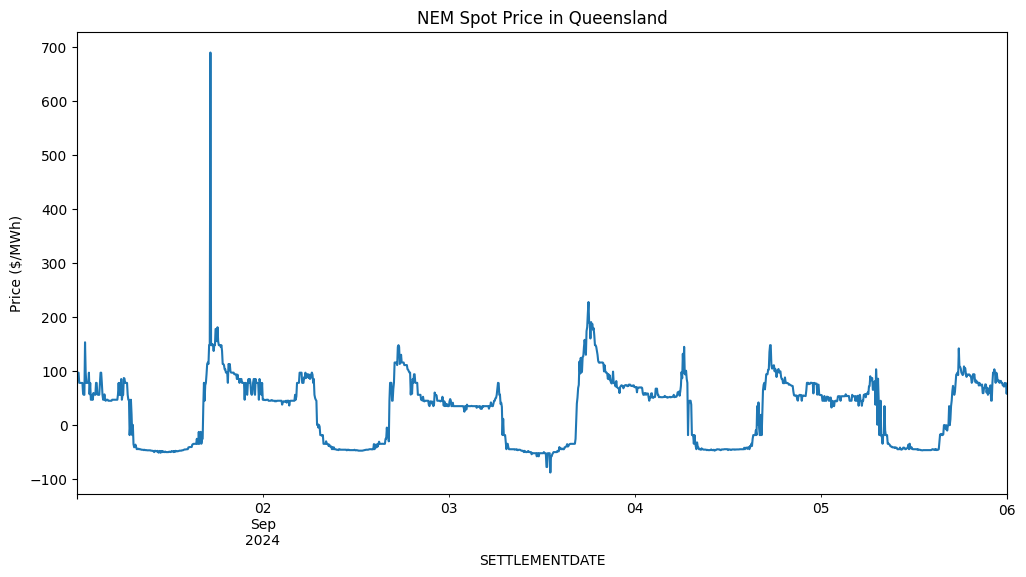

In [6]:
data.RRP.plot(figsize=(12, 6), title='NEM Spot Price in Queensland', ylabel='Price ($/MWh)')

In [7]:
hourly_data = data.groupby(data.index.strftime('%Y-%m-%d %H')).RRP.mean()
hourly_data.index = pd.to_datetime(hourly_data.index, format='%Y-%m-%d %H')

<Axes: title={'center': 'NEM Spot Price in Queensland'}, xlabel='SETTLEMENTDATE', ylabel='Price ($/MWh)'>

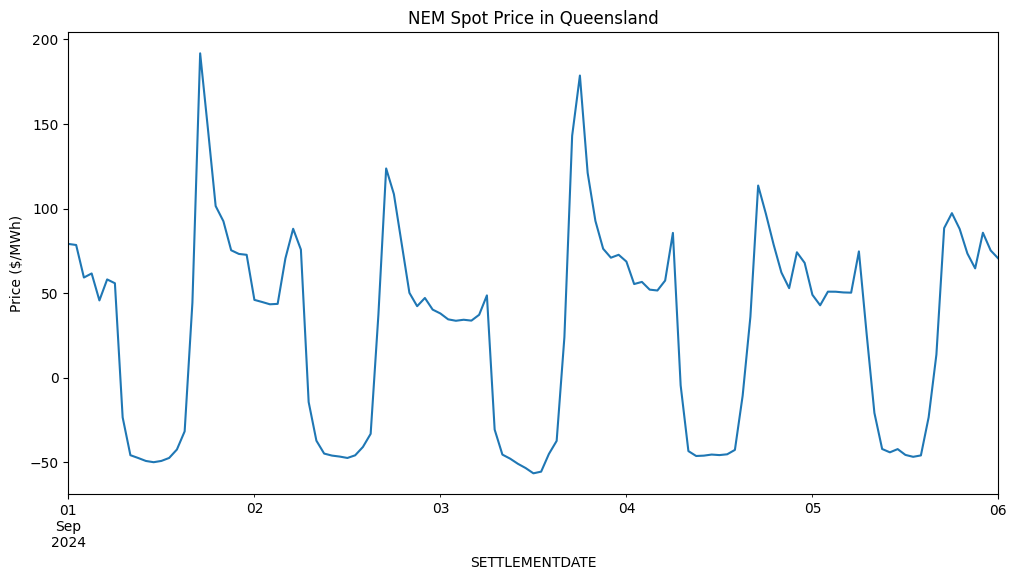

In [8]:
hourly_data.plot(figsize=(12, 6), title='NEM Spot Price in Queensland', ylabel='Price ($/MWh)')

---
## Building the Optimisation Model

We use the `PuLP` library to build the optimisation model. This model is formulated as a Mixed-Integer Linear Program (MILP), which aims to maximise profit by optimising the battery's charging and discharging activities based on the forecasted hourly spot prices.

### Key Model Components:
- **Objective Function**: Maximise the profit over the considered time range by optimising when to charge and discharge the battery.
- **Decision Variables**: 
  - Charge/discharge rates (MW)
  - State of charge (SOC, %)
  - Binary variables indicating whether the battery is charging or discharging
- **Constraints**:
  - Initial SOC value
  - Mutual exclusivity of charging and discharging
  - Charging and discharging rates limited by a maximum rate
  - The SOC in the current timestep must account for the previous SOC, adjusted by charge/discharge rates and efficiencies.
- **Limitations / Assumptions**:
  - We haven't considered:
    - battery degradation
    - SOC dependent charge/discharge rates
    - fixed/varibale costs including grid fees
  - We are also assuming that we have been able to successfully bid for our Battery Energy Storage System to discharge the modelled amounts in the appropriate time period.
  - Finally, we are using an hourly average price on any given day as a placeholder for a price forecast model. This means we are fitting to the real data.

The assumptions and limitations have been put in place in this demo in the interest of time, and a real-world model would use a production grade forecast model, as well as more realistic battery physics and market dynamics.

### Key Equations:
#### Objective Function

The objective of the optimisation problem is to maximise profit, which is the revenue from discharging the battery minus the cost of charging it. The objective function is given by:

$$\max\left(\pi_{total}\right) = \max \left( \sum_{t=0}^{T-1} \left( \eta_d \cdot P_t \cdot d_t - \frac{P_t \cdot c_t}{\eta_c} \right) \right)$$

where:
- $P_t$ is the electricity price at time $t$,
- $d_t$ is the amount of discharge at time $t$,
- $c_t$ is the amount of charge at time $t$,
- $\eta_d$ and $\eta_c$ are the discharge and charge efficiencies, respectively.

#### Constraints

1. **State of Charge (SOC) Dynamics:**

The state of charge (SOC) of the battery evolves over time based on the previous SOC, the amount of charge, and the amount of discharge. The SOC constraint for each time step is:

$$E_t = E_{t-1} + \eta_c \cdot c_t - \frac{d_t}{\eta_d} \quad \forall t \geq 1$$

where:
- $E_t$ is the state of charge at time $t$,
- $E_{t-1}$ is the state of charge at the previous time step.

2. **Initial SOC & Charge/Discharge Constraint:**

The initial SOC, charge, and discharge rates of the battery are given by:

$$
E_0 = E_{\text{initial}}
$$
$$
c_0 = c_{\text{initial}}
$$
$$
d_0 = d_{\text{initial}}
$$

Where $E_{\text{initial}}$, $c_{\text{initial}}$, and $d_{\text{initial}}$ are predefined values.

3. **Mutual Exclusivity of Charging and Discharging:**

The battery cannot charge and discharge simultaneously. This is ensured with the following constraint:

$$
u_t + v_t \leq 1 \quad \forall t
$$

where:
- $u_t $ is a binary variable indicating charging ($u_t = 1$) or not ($u_t = 0$),
- $v_t $ is a binary variable indicating discharging ($v_t = 1$) or not ($v_t = 0$).

4. **Charging and Discharging Limits:**

The charging and discharging rates are constrained by a maximum power limit $P_{\text{max}}$. These constraints are expressed as:

$$
0 \leq c_t \leq P_{\text{max}} \cdot u_t \quad \forall t
$$
$$
0 \leq d_t \leq P_{\text{max}} \cdot v_t \quad \forall t
$$

where:
- $P_{\text{max}} $ is the maximum charging/discharging power.

5. **State of Charge Bound:**

The SOC at any time must not exceed the battery's maximum capacity $E_{\text{max}}$:

$$
0 \leq E_t \leq E_{\text{max}} \quad \forall t
$$

#### Solution Extraction

Once the problem is solved, the optimal values for charging $c_t$, discharging $d_t$, and the state of charge $E_t $ at each time step $t $ can be extracted.

The total profit can be calculated as:

$$
\pi_{\text{total}} = \sum_{t=0}^{T-1} \left( \eta_d \cdot P_t \cdot d_t - \frac{P_t \cdot c_t}{\eta_c} \right)
$$


In [9]:
def optimal_battery_schedule_pulp(prices, eta_c, eta_d, E_max, P_max, E_0):
    T = len(prices)  # Number of time steps

    # Create a problem variable
    prob = pulp.LpProblem("Optimal_Battery_Schedule", pulp.LpMaximize)

    # Decision variables:
    c = pulp.LpVariable.dicts("charge", range(T), lowBound=0, upBound=P_max, cat=pulp.LpContinuous)
    d = pulp.LpVariable.dicts("discharge", range(T), lowBound=0, upBound=P_max, cat=pulp.LpContinuous)
    E = pulp.LpVariable.dicts("SOC", range(T), lowBound=0, upBound=E_max, cat=pulp.LpContinuous)
    u = pulp.LpVariable.dicts("charge_indicator", range(T), lowBound=0, upBound=1, cat=pulp.LpBinary)
    v = pulp.LpVariable.dicts("discharge_indicator", range(T), lowBound=0, upBound=1, cat=pulp.LpBinary)

    # Objective: Maximise profit (revenue from discharge minus cost of charging)
    prob += pulp.lpSum([prices[t] * d[t] * eta_d - prices[t] * c[t] / eta_c for t in range(T)])

    # Constraints:
    
    # SOC dynamics: E_t = E_(t-1) + c_t*eta_c - d_t*(1/eta_d)
    for t in range(1, T):
        prob += E[t] == E[t-1] + c[t] * eta_c - d[t] * (1 / eta_d)

    # Initial SOC constraint: E_1 = E_0
    prob += E[0] == E_0

    # Initial charging and discharging constraint (no charging or discharging at t=0): c_0 = d_0 = 0
    prob += c[0] == 0
    prob += d[0] == 0

    # Mutual exclusivity of charging and discharging: u_t + v_t <= 1
    for t in range(T):
        prob += u[t] + v[t] <= 1

    # Charging and discharging power limits: 0 <= c_t <= P_max*u_t, 0 <= d_t <= P_max*v_t
    for t in range(T):
        prob += c[t] <= P_max * u[t]
        prob += d[t] <= P_max * v[t]

    # Solve the problem
    prob.solve()

    # Check if the optimisation was successful
    if pulp.LpStatus[prob.status] == 'Optimal':
        # Extract the results
        charging = [pulp.value(c[t]) for t in range(T)]
        discharging = [pulp.value(d[t]) for t in range(T)]
        soc = [pulp.value(E[t]) for t in range(T)]
        cashflow = [prices[t] * discharging[t] * eta_d - prices[t] * charging[t] / eta_c for t in range(T)]
        objective = pulp.value(prob.objective)
        return charging, discharging, soc, cashflow, objective
    else:
        raise ValueError("Optimisation failed")


---
## Running the Model over a 6-Day Period

The model is applied over a 6-day period for Sep 24, where we treat the smoothed hourly spot-price data as a forecast model output. This is an obvious look-ahead bias but has been made for simplicity and the consideration of time. 

The optimisation output takes advantage of significant price fluctuations. The battery charging/discharging pattern is largely centred around charging during the day when solar PV is online and the spot price drops substantially due to the large drop in demand, and then discharging in the early evening as demand rises sharply and solar PV goes offline.

### Observations:
- The model effectively captures price changes, especially during midday solar production and nighttime demand troughs.
- Several limitations exist, including:
  - No penalties for degradation or dynamic charging rates which would lead the model to be charging/discharge less frequently
  - Lack of real-world price volatility due to the smoothed price data
  - The use of actual data for "forecasting," which is simply a placeholder and should be replaced by a proper forecasting model.

The results show that while the battery optimisation strategy performs well under these conditions, further enhancements are needed to account for real-world complexities.

In [10]:
prices = hourly_data
eta_c = 0.95  # Charging efficiency
eta_d = 0.95  # Discharging efficiency
E_max = 100  # Maximum capacity (MWh)
P_max = 20  # Maximum charging/discharging power (MW)
E_0 = 0  # Initial state of charge (MWh)

charging, discharging, soc, cashflow, objective = optimal_battery_schedule_pulp(prices, eta_c, eta_d, E_max, P_max, E_0)

print(f"${objective:,.2f}")


C:\Users\Jack.Sweep2\AppData\Local\Temp\ipykernel_31308\3176222236.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prob += pulp.lpSum([prices[t] * d[t] * eta_d - prices[t] * c[t] / eta_c for t in range(T)])


$74,572.17


C:\Users\Jack.Sweep2\AppData\Local\Temp\ipykernel_31308\3176222236.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cashflow = [prices[t] * discharging[t] * eta_d - prices[t] * charging[t] / eta_c for t in range(T)]


In [11]:
output = pd.DataFrame({'Charge (MW)': charging, 'Discharge (MW)': discharging, 'SOC (MWh)': soc, 'Cashflow ($)': cashflow, 'Price ($/MWh)': prices.values}, index=prices.index)

In [12]:
real_cashflow = []
for t, price in data['2024-09-02':].RRP.items():
    hourly_index = t.replace(minute=0, second=0) - pd.Timedelta(days=1) # use the previous day's "forecat" SOC data for the current day to counter the look-ahead bias
    discharge_val, charge_val = output.loc[hourly_index, "Discharge (MW)"], output.loc[hourly_index, "Charge (MW)"]
    real_cashflow.append((5/60)*(price * discharge_val * eta_d - price * charge_val / eta_c)) # using the real price data, adjusted for 5 minute intervals

In [13]:
output = output.loc['2024-09-02':]

Modelled Profit: $74,572.17
Real Profit: $54,739.03


Text(0, 0.5, 'Real Cashflow ($)')

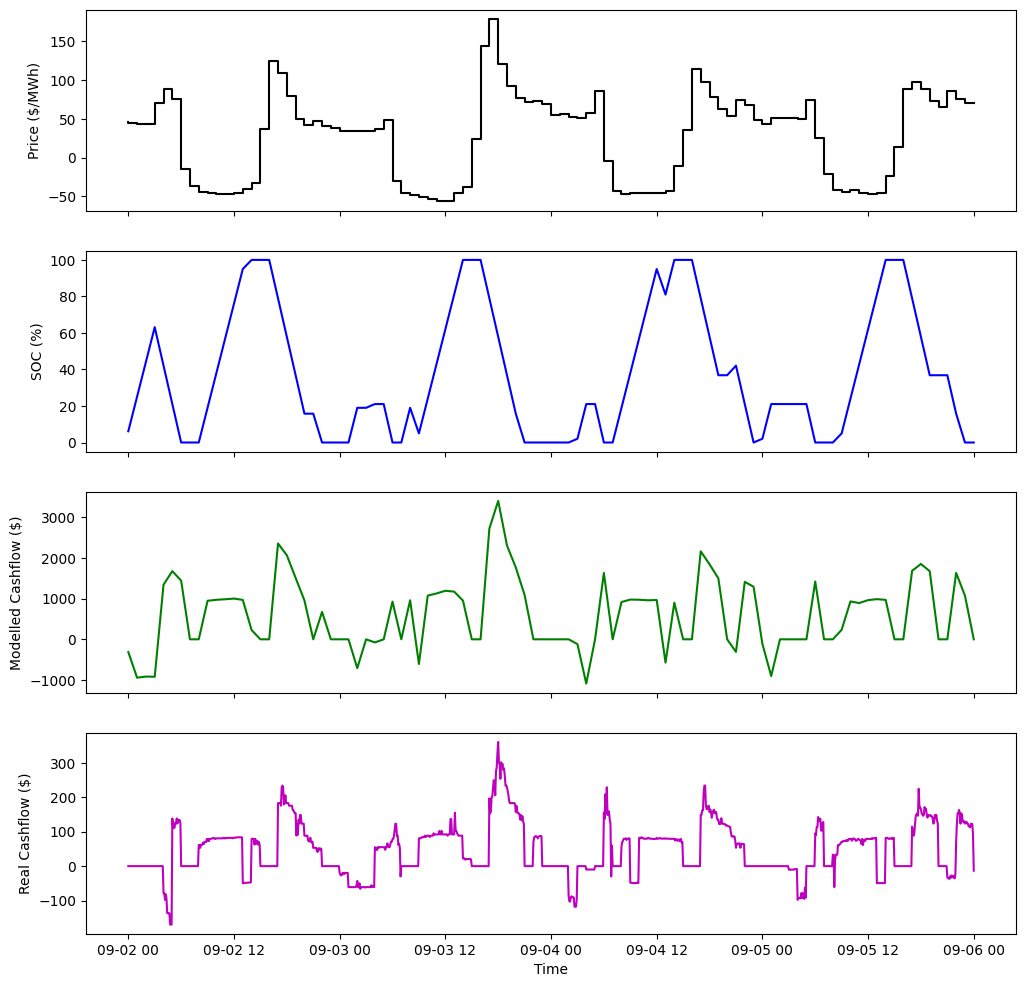

In [14]:
print(f"Modelled Profit: ${objective:,.2f}")
print(f"Real Profit: ${sum(real_cashflow):,.2f}")
fig, ax = plt.subplots(figsize=(12, 12), nrows=4, sharex=True)
_ = ax[0].step(output.index, output['Price ($/MWh)'], '-k', label='Price')
_ = ax[1].plot(output.index, output['SOC (MWh)'], '-b', label='SOC')
_ = ax[2].plot(output.index, output['Cashflow ($)'], '-g', label='Cashflow ($)')
_ = ax[3].plot(data['2024-09-02':].index, real_cashflow, '-m', label='Real Cashflow ($)')
ax[3].set_xlabel('Time')
ax[0].set_ylabel('Price ($/MWh)')
ax[1].set_ylabel('SOC (%)')
ax[2].set_ylabel('Modelled Cashflow ($)')
ax[3].set_ylabel('Real Cashflow ($)')

---
## Running the Model over CY24 YTD

We now apply the model over the entire CY24 period so far. Again, we treat the smoothed hourly spot-price data as a forecast. As the demand pattern is predominantly daily, we can simplify the problem computationally to optimise each day's battery arbitrage and then stitch together the optimisations by setting the SOC of the next day to be equal to the end of the previous day's optimisation.

Over the course of CY24 we see that prices have varied substantially, occassionally almost hitting the capped ceiling for spot price value.

To help counter the lookahead bias, we use the model's previous day's SOC outputs and the current day's 5-min pricing to determine the "real" cashflows

The net profit of this model works out to be approximately $5M for a 100MWh battery with 20MW charge/discharge rate. This model is idealised in the ways we have mentioned previously. Next steps would be to include realistic battery and market dynamics, as well as use a proper forecast model for the pricing inputs.

We could also change out this traditional optimisation approach with an alternative form of model such as a traditional ML model predicting charge/discharge rates, or an RL Agent trained with a reward function coupled to overall profit.

In [15]:
# Let's now run this for the whole year to date
# get all the CSV data in the data folder
import os
import glob

data_folder = r"..\data"
csv_files = glob.glob(os.path.join(data_folder, "*.csv"))

# Load all the data into a single DataFrame
data = pd.concat([pd.read_csv(f, date_format='%Y-%m-%d %H:%M:%S', parse_dates=['SETTLEMENTDATE']) for f in csv_files])

In [16]:
data['SETTLEMENTDATE'] = pd.to_datetime(data['SETTLEMENTDATE'])

In [17]:
data.set_index('SETTLEMENTDATE', inplace=True)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71712 entries, 2024-01-01 00:05:00 to 2024-09-06 00:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   REGION       71712 non-null  object 
 1   TOTALDEMAND  71712 non-null  float64
 2   RRP          71712 non-null  float64
 3   PERIODTYPE   71712 non-null  object 
dtypes: float64(2), object(2)
memory usage: 2.7+ MB


In [19]:
hourly_data = data.groupby(data.index.strftime('%Y-%m-%d %H')).RRP.mean()
hourly_data.index = pd.to_datetime(hourly_data.index, format='%Y-%m-%d %H')

<Axes: xlabel='SETTLEMENTDATE'>

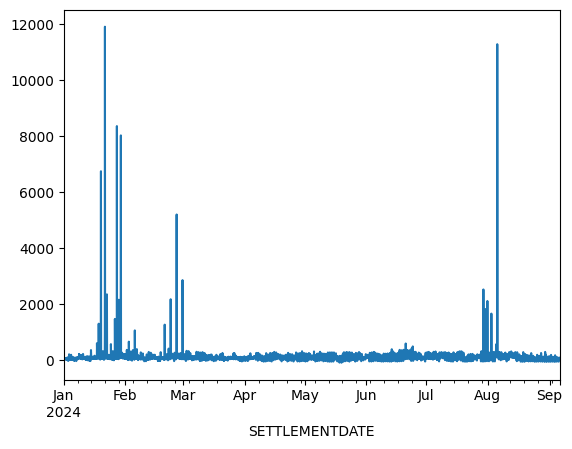

In [20]:
hourly_data.plot()

In [21]:
hourly_data.head()

SETTLEMENTDATE
2024-01-01 00:00:00    64.049091
2024-01-01 01:00:00    51.865833
2024-01-01 02:00:00    53.718333
2024-01-01 03:00:00    51.587500
2024-01-01 04:00:00    45.140833
Name: RRP, dtype: float64

In [22]:
# for each day in the data, run the optimisation, and store the results
eta_c = 0.95  # Charging efficiency
eta_d = 0.95  # Discharging efficiency
E_max = 100  # Maximum capacity (MWh)
P_max = 20  # Maximum charging/discharging power (MW)
E_0 = 0  # Initial state of charge (MWh)

idx = 0
day_results = []
for day, prices in hourly_data.groupby(hourly_data.index.date):
    if idx % 30 == 0:
        print(f"Processing day {idx}")
    charging, discharging, soc, cashflow, objective = optimal_battery_schedule_pulp(prices, eta_c, eta_d, E_max, P_max, E_0)
    day_results.append(pd.DataFrame({'Charge (MW)': charging, 'Discharge (MW)': discharging, 'SOC (MWh)': soc, 'Cashflow ($)': cashflow, 'Price ($/MWh)': prices.values}, index=prices.index))
    E_0 = soc[-1] # set the initial state of charge for the next day to the final state of charge of the current day
    idx += 1

Processing day 0


C:\Users\Jack.Sweep2\AppData\Local\Temp\ipykernel_31308\3176222236.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prob += pulp.lpSum([prices[t] * d[t] * eta_d - prices[t] * c[t] / eta_c for t in range(T)])
C:\Users\Jack.Sweep2\AppData\Local\Temp\ipykernel_31308\3176222236.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cashflow = [prices[t] * discharging[t] * eta_d - prices[t] * charging[t] / eta_c for t in range(T)]


Processing day 30
Processing day 60
Processing day 90
Processing day 120
Processing day 150
Processing day 180
Processing day 210
Processing day 240


In [23]:
df = pd.concat(day_results)

In [24]:
df.head()

,Charge (MW),Discharge (MW),SOC (MWh),Cashflow ($),Price ($/MWh)
SETTLEMENTDATE,,,,,
2024-01-01 00:00:00,0.0,0.0,0.0,0.0,64.049091
2024-01-01 01:00:00,0.0,0.0,0.0,0.0,51.865833
2024-01-01 02:00:00,0.0,0.0,0.0,0.0,53.718333
2024-01-01 03:00:00,0.0,0.0,0.0,0.0,51.587500
2024-01-01 04:00:00,0.0,0.0,0.0,0.0,45.140833


In [25]:
data.iloc[0].name + pd.Timedelta(days=1)

Timestamp('2024-01-02 00:05:00')

In [26]:
real_cashflow = []
for t, price in data.loc['2024-01-02':].RRP.items(): 
    hourly_index = t.replace(minute=0, second=0) - pd.Timedelta(days=1) # use the previous day's "forecat" SOC data for the current day to counter the look-ahead bias
    discharge_val, charge_val = df.loc[hourly_index, "Discharge (MW)"], df.loc[hourly_index, "Charge (MW)"]
    real_cashflow.append((5/60)*(price * discharge_val * eta_d - price * charge_val / eta_c)) # adjusted for 5 minute intervals

Modelled Profit: $6,000,757.33
Real Profit: $5,077,096.35


Text(0, 0.5, 'Real Cashflow ($)')

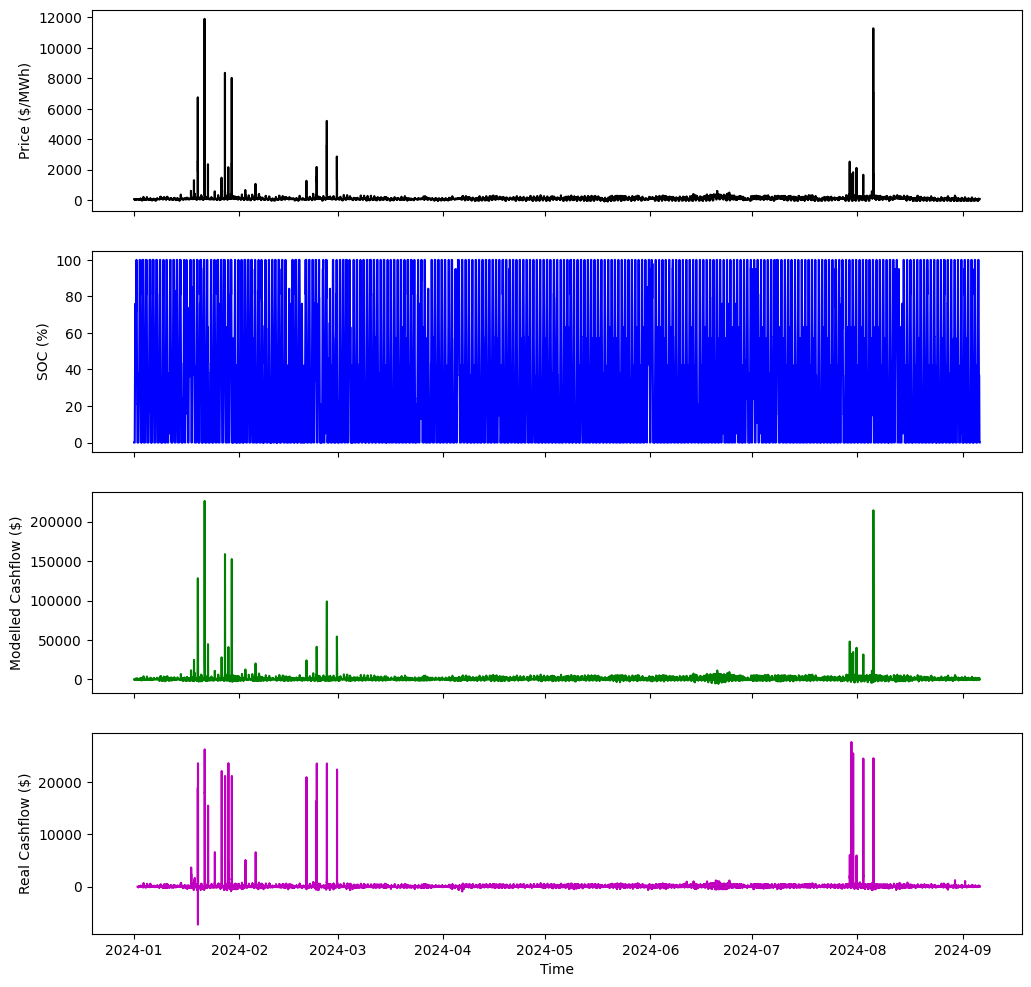

In [28]:
print(f"Modelled Profit: ${sum(df.loc[:, 'Cashflow ($)']):,.2f}")
print(f"Real Profit: ${sum(real_cashflow):,.2f}")
fig, ax = plt.subplots(figsize=(12, 12), nrows=4, sharex=True)
_ = ax[0].step(df.loc[:, "Price ($/MWh)"], '-k', label='Price')
_ = ax[1].plot(df.loc[:, "SOC (MWh)"], '-b', label='SOC')
_ = ax[2].plot(df.loc[:, "Cashflow ($)"], '-g', label='Cashflow ($)')
_ = ax[3].plot(data.loc['2024-01-02':].index, real_cashflow, '-m', label='Real Cashflow ($)')
ax[3].set_xlabel('Time')
ax[0].set_ylabel('Price ($/MWh)')
ax[1].set_ylabel('SOC (%)')
ax[2].set_ylabel('Modelled Cashflow ($)')
ax[3].set_ylabel('Real Cashflow ($)')

### Let's now consider how we could build a similar Reinforcement Learning based agent in this arbitrage situation

This is a toy example, not intended to be used in reality, but to show how we could approach the issue using the well-known OpenAI gym library and a Proximal Policy Optimisation approach.

I've used a CPU for this training, and very limited number of runs to simply illustrate the initial approach.

We should also be implementing some guardrail system around an approach like this to ensure any unwanted actions are prevented.

Finally, we do not split the data into a test/train split and don't use any serious validation approaches.


We can see at this stage of training, the agent is not fully charging and discharging the battery each day even though this is a natural frequency of the market dynamics at play. We can also see that there is clearly an issue with the charging/discharging. We never hit the limits on either end of the spectrum

In [55]:
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
import numpy as np

# Define the custom Gym environment with normalized action space
class BatteryEnv(gym.Env):
    def __init__(self, prices, eta_c, eta_d, E_max, P_max, E_0):
        super(BatteryEnv, self).__init__()
        self.prices = prices.values
        self.eta_c = eta_c
        self.eta_d = eta_d
        self.E_max = E_max
        self.P_max = P_max
        self.E_0 = E_0
        self.max_steps = len(self.prices)
        self.current_step = 0
        self.E = E_0  # Current state of charge

        # Action space: Normalized to [-1, 1], where -1 corresponds to maximum discharge and 1 to maximum charge
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        # Observation space: Price at time t and current SOC
        self.observation_space = spaces.Box(low=np.array([0, 0]), high=np.array([np.inf, E_max]), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.E = self.E_0
        return np.array([self.prices[self.current_step], self.E], dtype=np.float32), {}

    def step(self, action):
        price = self.prices[self.current_step]

        # Rescale action from [-1, 1] to [-P_max, P_max]
        scaled_action = action[0] * self.P_max

        # Update SOC based on action (positive is charging, negative is discharging)
        if scaled_action >= 0:
            # Charging
            c = min(scaled_action, (self.E_max - self.E) / self.eta_c)
            self.E += c * self.eta_c
            cost = -price * c
        else:
            # Discharging
            d = min(-scaled_action, self.E * self.eta_d)
            self.E -= d / self.eta_d
            cost = price * d

        reward = cost  # Profit (positive if discharging at high prices, negative if charging at low prices)
        self.current_step += 1
        done = self.current_step >= self.max_steps
        truncated = False  # No truncation logic in this environment

        if not done:
            obs = np.array([self.prices[self.current_step], self.E], dtype=np.float32)
        else:
            obs = np.array([0, self.E], dtype=np.float32)  # Dummy observation at the end

        info = {}
        return obs, reward, done, truncated, info

    def render(self, mode='human'):
        pass  # Not implemented

    def close(self):
        pass  # Not implemented

# Prepare the data for the environment
prices = hourly_data.loc['2024-01-01':]  # Use the same hourly prices
eta_c = 0.95
eta_d = 0.95
E_max = 100
P_max = 20
E_0 = 0

# Initialize the environment
env = BatteryEnv(prices, eta_c, eta_d, E_max, P_max, E_0)

# Define the model
model = PPO("MlpPolicy", env, verbose=1)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [56]:
# Train the model
model.learn(total_timesteps=10000)


-----------------------------
| time/              |      |
|    fps             | 2922 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1007         |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.009450228  |
|    clip_fraction        | 0.109        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 6.556511e-07 |
|    learning_rate        | 0.0003       |
|    loss                 | 3.97e+07     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00902     |
|    std                  | 0.994        |
|    value_loss           | 1.26e+08     |
----------------

Total Profit from RL agent: $727,274.69


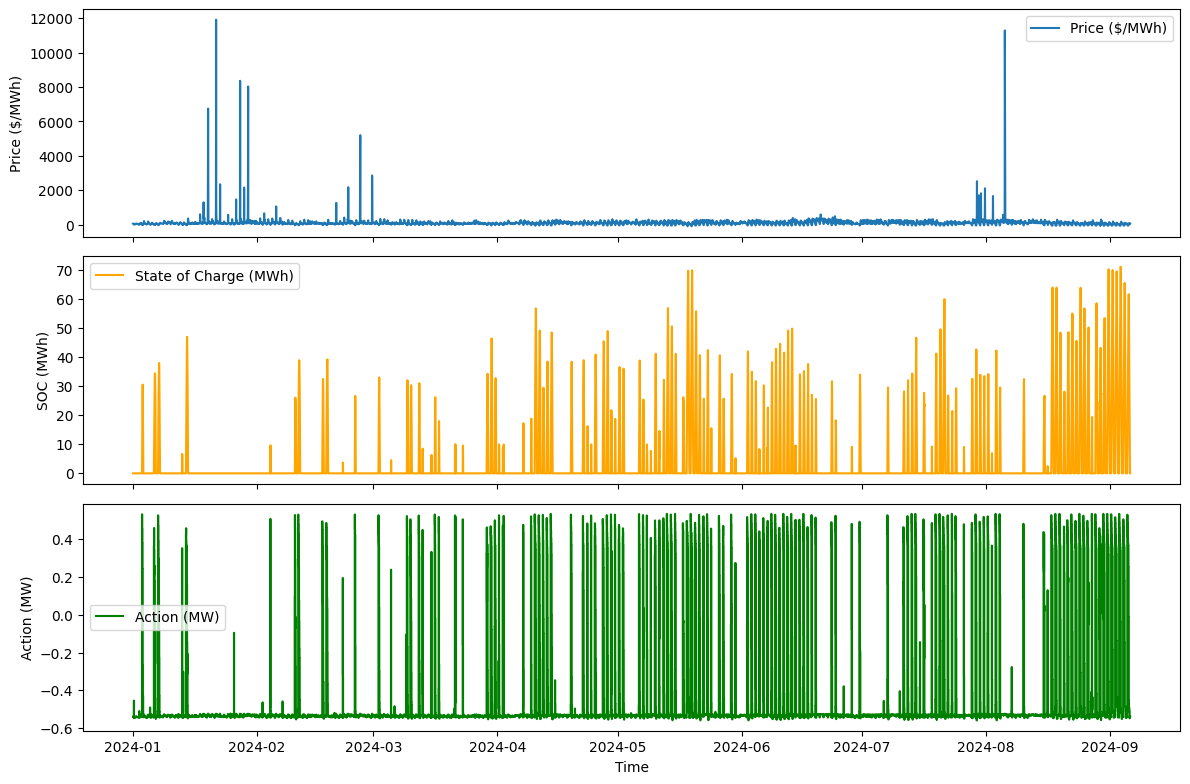

In [57]:
# Evaluate the trained agent
obs, _ = env.reset()
rewards = []
soc_history = []
actions = []
for _ in range(len(prices)):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    rewards.append(reward)
    soc_history.append(env.E)
    actions.append(action[0])
    if done:
        break

# Calculate total profit
total_profit = sum(rewards)
print(f"Total Profit from RL agent: ${total_profit:,.2f}")

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8), nrows=3, sharex=True)
ax[0].plot(prices.index[:len(actions)], prices.values[:len(actions)], label='Price ($/MWh)')
ax[0].set_ylabel('Price ($/MWh)')
ax[0].legend()
ax[1].plot(prices.index[:len(actions)], soc_history, label='State of Charge (MWh)', color='orange')
ax[1].set_ylabel('SOC (MWh)')
ax[1].legend()
ax[2].step(prices.index[:len(actions)], actions, label='Action (MW)', color='green')
ax[2].set_ylabel('Action (MW)')
ax[2].set_xlabel('Time')
ax[2].legend()
plt.tight_layout()
plt.show()